100%|██████████| 170498071/170498071 [00:02<00:00, 59756565.38it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Epoch 1/20, Train Loss: 1.5622, Train Accuracy: 43.17%, Val Loss: 1.3504, Val Accuracy: 51.11%
Epoch 2/20, Train Loss: 1.2094, Train Accuracy: 56.77%, Val Loss: 1.1903, Val Accuracy: 57.19%
Epoch 3/20, Train Loss: 1.0360, Train Accuracy: 63.31%, Val Loss: 1.0346, Val Accuracy: 62.87%
Epoch 4/20, Train Loss: 0.8973, Train Accuracy: 68.22%, Val Loss: 0.9554, Val Accuracy: 66.30%
Epoch 5/20, Train Loss: 0.7842, Train Accuracy: 72.36%, Val Loss: 0.9521, Val Accuracy: 66.81%
Epoch 6/20, Train Loss: 0.6794, Train Accuracy: 75.88%, Val Loss: 0.8999, Val Accuracy: 68.27%
Epoch 7/20, Train Loss: 0.5771, Train Accuracy: 79.66%, Val Loss: 0.9298, Val Accuracy: 68.87%
Epoch 8/20, Train Loss: 0.4778, Train Accuracy: 83.21%, Val Loss: 0.9841, Val Accuracy: 68.78%
Epoch 9/20, Train Loss: 0.3893, Train Accuracy: 86.52%, Val Loss: 1.0693, Val Accuracy: 68.11%
Epoch 10/20, Train Loss: 0.2993, Train Accuracy: 89.58%, Val

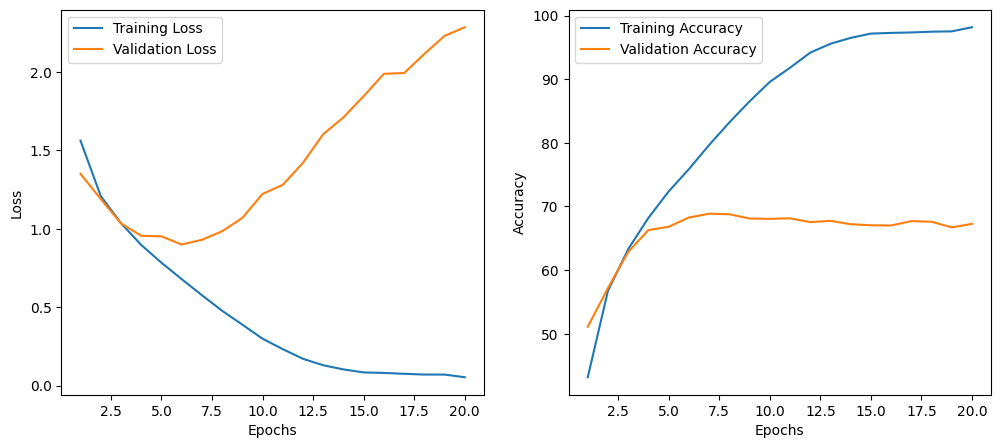

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data_utils
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fix random seeds for reproducibility
seed = 73
torch.manual_seed(seed)
np.random.seed(seed)

# Data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_data = CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = CIFAR10(root='data', train=False, download=True, transform=transform)

# Prepare dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False, num_workers=2)

# Autoencoder-based classification model (B1.0)
class AutoencoderClassifier(nn.Module):
    def __init__(self, input_shape, z_dim, output_shape):
        super(AutoencoderClassifier, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, z_dim),
            nn.ReLU(True)
        )
        self.classifier = nn.Linear(z_dim, output_shape)

    def forward(self, x):
        z = self.encoder(x)
        return self.classifier(z)

# Initialize model
z_dim = 256
output_shape = 10
model = AutoencoderClassifier(input_shape=(32, 32, 3), z_dim=z_dim, output_shape=output_shape).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

# Training and validation
epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100. * correct / total)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(100. * correct / total)

    print(f'Epoch {epoch+1}/{epochs}, '
          f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, '
          f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%')

# Plot loss and accuracy graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
